## Classification-powered Conformal Prediction

In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
path = 'data/data.csv'
data = pd.read_csv(path)
normalized_pctg_change = data['normalized_percent_change'] # Save variable fot later use in model
data.drop(columns=['normalized_percent_change'], inplace=True)

In [3]:
xgboost_df = data.copy()
# One-hot encoding
demographic_vars = ['gender_source_value', 'race_source_value', 'ethnicity_source_value']
xgboost_df = pd.get_dummies(xgboost_df, columns=demographic_vars)
# Scaling: Apparently there's no difference if a use a StandardScaler vs MinMaxScaler
scaler = MinMaxScaler()
numeric_vars = ['mean_led_per_visit', 'age', 'length_of_stay', 'days_since_last_visit', 'days_to_diagnosis']
for i in range(len(numeric_vars)):
    xgboost_df[numeric_vars[i]] = scaler.fit_transform(xgboost_df[[numeric_vars[i]]])

# Reordering the columns so that the target variable is the last one
prediction_to_last = xgboost_df.pop('prediction')
xgboost_df['prediction'] = prediction_to_last

# Defining the features and target variable
X = xgboost_df.iloc[:, :-1] # Shape is rows x features (38)
y = xgboost_df.iloc[:, -1]

# Split data into training and testing sets
# I don't need to use cupy or cudf to send the data to the GPU because I'm using DMatrix
random_state = 21
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = xgb.DMatrix(X_train, y_train, label=y_train)
d_test = xgb.DMatrix(X_test, y_test, label=y_test)

# Parameter previously calculated by doing hyperparameter tuning
# Note: Accuracy drops with L2 regularization and higher depth. A smaller L1 regularization bumps the model
# Note: When I avoid dropping nas in mean_led_per_patient accuracy bumps to 91%
# Note: -> Remove the least importanf features in the model and run until you find the appropiate number of features
# Model seems to perform better when I use train instead of XGBClassifier
best_params = {
    # Classification
    "eval_metric": "auc", # Area under the curve
    # "eval_metric": "mlogloss" For multiclass
    "objective": "binary:logistic", # Logistic regression for binary classification, output probability
    # "objective": "multi:softprob", # Multi-class classification
    # 'num_class': 3, # Number of classes (required when doing multi-class classification)
    # Regression:
    # "eval_metric": 'rmse',
    # 'objective': 'reg:squarederror',
    'sampling_method': 'gradient_based', # The selection probability for each training instance is proportional to the regularized absolute value of gradients 
    'alpha': 0.1, # L1 regularization
    'lambda': 1, # L2 regularization
    'learning_rate': 0.1, 
    'max_depth': 7,
    'num_boost_round': 700, 
    'tree_method': 'hist', 
    'device': "cuda",
}
num_boost_round = best_params['num_boost_round']
# Prior AUC: 0.86066216116602046
# Best new = 0.92090948515188154 difference is nwq 
regression_params_short = {'alpha': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 28/08/2024. Range (0,1)
regression_params_long = {'alpha': 1, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 01/09/2024. Range (-1,1) Decreases coverage in Jackknife+ by 0.02
binary_params = {'alpha': 0, 'lambda': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 800, "eval_metric": 'auc', 'objective': 'binary:logistic', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda",} 

# Create and train the XGBoost model
# model = xgb.XGBClassifier(**best_params, verbosity=2, tree_method="hist", device="cuda")
# model = xgb.XGBClassifier(verbosity=2, tree_method="hist", device="cuda")
# model.fit(X_train, y_train)
model = xgb.train(best_params, d_train, num_boost_round=num_boost_round, evals=((d_test, "test"),),verbose_eval=True, early_stopping_rounds=10)

# Make predictions
y_pred_proba = model.predict(d_test, iteration_range=(0, model.best_iteration + 1))

# For Binary classification
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# For multi-class classification
# y_pred = np.argmax(y_pred_proba, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

results = model.eval(d_test)

print('AUC:', results)
print("ACC:", accuracy)
# file.write(f"AUC XGBoost Model: {results} Time Window: {time_window}\n")

[0]	test-auc:0.86294
[1]	test-auc:0.86382
[2]	test-auc:0.87933
[3]	test-auc:0.88895
[4]	test-auc:0.89025
[5]	test-auc:0.89470
[6]	test-auc:0.89596
[7]	test-auc:0.89800
[8]	test-auc:0.89995
[9]	test-auc:0.90051
[10]	test-auc:0.90198
[11]	test-auc:0.90364
[12]	test-auc:0.90498
[13]	test-auc:0.90394
[14]	test-auc:0.90669
[15]	test-auc:0.90791
[16]	test-auc:0.91025
[17]	test-auc:0.91106
[18]	test-auc:0.91245
[19]	test-auc:0.91457
[20]	test-auc:0.91526
[21]	test-auc:0.91669
[22]	test-auc:0.91825
[23]	test-auc:0.91827
[24]	test-auc:0.91895
[25]	test-auc:0.91995
[26]	test-auc:0.92116
[27]	test-auc:0.92150
[28]	test-auc:0.92219
[29]	test-auc:0.92224
[30]	test-auc:0.92256
[31]	test-auc:0.92388
[32]	test-auc:0.92452
[33]	test-auc:0.92480
[34]	test-auc:0.92626
[35]	test-auc:0.92725
[36]	test-auc:0.92796
[37]	test-auc:0.92874
[38]	test-auc:0.92923
[39]	test-auc:0.92959
[40]	test-auc:0.92964
[41]	test-auc:0.92987
[42]	test-auc:0.93013
[43]	test-auc:0.93105
[44]	test-auc:0.93176
[45]	test-auc:0.9320

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[51]	test-auc:0.93615
[52]	test-auc:0.93664
[53]	test-auc:0.93707
[54]	test-auc:0.93782
[55]	test-auc:0.93816
[56]	test-auc:0.93814
[57]	test-auc:0.93839
[58]	test-auc:0.93877
[59]	test-auc:0.93946
[60]	test-auc:0.93984
[61]	test-auc:0.94022
[62]	test-auc:0.94035
[63]	test-auc:0.94063
[64]	test-auc:0.94162
[65]	test-auc:0.94183
[66]	test-auc:0.94225
[67]	test-auc:0.94252
[68]	test-auc:0.94300
[69]	test-auc:0.94326
[70]	test-auc:0.94375
[71]	test-auc:0.94465
[72]	test-auc:0.94495
[73]	test-auc:0.94504
[74]	test-auc:0.94561
[75]	test-auc:0.94609
[76]	test-auc:0.94658
[77]	test-auc:0.94715
[78]	test-auc:0.94728
[79]	test-auc:0.94766
[80]	test-auc:0.94787
[81]	test-auc:0.94791
[82]	test-auc:0.94912
[83]	test-auc:0.94931
[84]	test-auc:0.94967
[85]	test-auc:0.94969
[86]	test-auc:0.94961
[87]	test-auc:0.94970
[88]	test-auc:0.94978
[89]	test-auc:0.94994
[90]	test-auc:0.95027
[91]	test-auc:0.95048
[92]	test-auc:0.95081
[93]	test-auc:0.95106
[94]	test-auc:0.95099
[95]	test-auc:0.95132
[96]	test-

In [4]:
# Get probabilities for all data
d_all = xgb.DMatrix(X)
# Predictions for the whole dataset
y_pred_proba_conformal = model.predict(d_all, iteration_range=(0, model.best_iteration + 1))
q1, q2, q3 = np.percentile(y_pred_proba_conformal, [25, 50, 75])
# Step 2: Create different cutoffs based on predicted probabilities
# Changing current params to do Regression and use RMSE for evaluation
best_params["eval_metric"] = 'rmse'
best_params['objective'] = 'reg:squarederror'
num_boost_round = best_params['num_boost_round']
cutoffs = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]
cutoffs.append(q1)
cutoffs.append(q2)
cutoffs.append(q3)
cutoffs = sorted(cutoffs)
cutoff = cutoffs[7]
xgboost_df['prediction'] = normalized_pctg_change
filtered_df = xgboost_df[y_pred_proba_conformal > cutoff]
X_2 = filtered_df.iloc[:, :-1]
y_2 = filtered_df.iloc[:, -1]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=random_state)

# Create DMatrix for XGBoost
d_train_2 = xgb.DMatrix(X_train_2, label=y_train_2)
d_test_2 = xgb.DMatrix(X_test_2, label=y_test_2)

# Train the second model (XGBoost Regressor)
regression_model = xgb.train(best_params, d_train_2, num_boost_round=num_boost_round, evals=[(d_train_2, "train"), (d_test_2, "test")], verbose_eval=100, early_stopping_rounds=10)

[0]	train-rmse:0.61394	test-rmse:0.60314


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.18630	test-rmse:0.25258
[182]	train-rmse:0.16455	test-rmse:0.24031


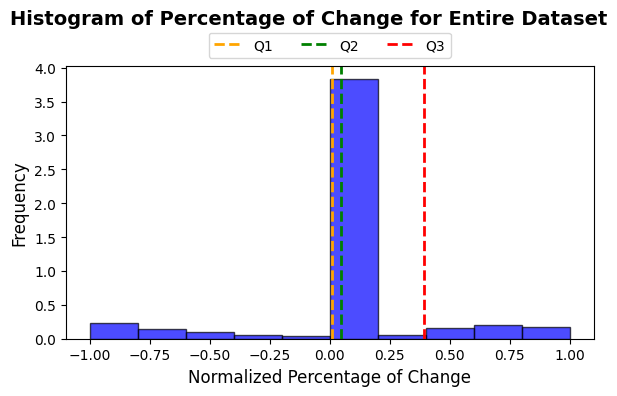

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
bins = int(np.sqrt(len(normalized_pctg_change)))
# Box plot
# axs[0].boxplot(normalized_pctg_change, labels=[''], patch_artist=True, boxprops=dict(facecolor=color_azure), medianprops=dict(color=color_orange))
# axs[0].set_title("Bloxplot of Predicted Change for Entire Set", fontsize=12, fontweight='bold')
# axs[0].set_ylabel('Prediction')
# Histogram
ax.hist(normalized_pctg_change, bins=10, alpha=0.7, color='blue', edgecolor='black', density=True)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Normalized Percentage of Change', fontsize=12)
fig.suptitle('Histogram of Percentage of Change for Entire Dataset', fontsize=14, fontweight='bold')
# Quantiles
ax.axvline(q1, color='orange', linestyle='dashed', linewidth=2, label='Q1')
ax.axvline(q2, color='green', linestyle='dashed', linewidth=2, label='Q2')
ax.axvline(q3, color='red', linestyle='dashed', linewidth=2, label='Q3')
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, labels, ncol=3, fontsize=10, bbox_to_anchor=(0.5, 1.15), loc='upper center'
)
plt.subplots_adjust(hspace=0.1, top=0.5)
plt.tight_layout()
plt.show()

RMSE: 0.24035996496809864
MAE: 0.13816617846807563
R²: 0.8551817392637242


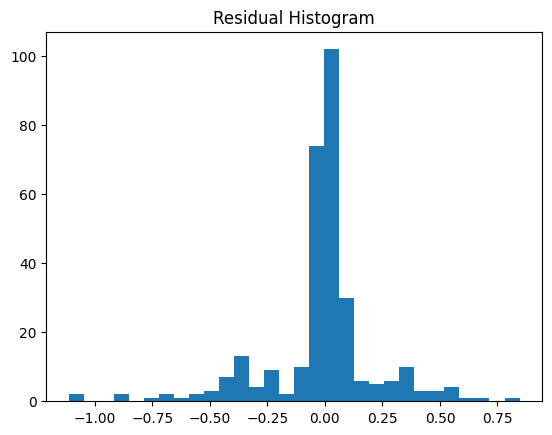

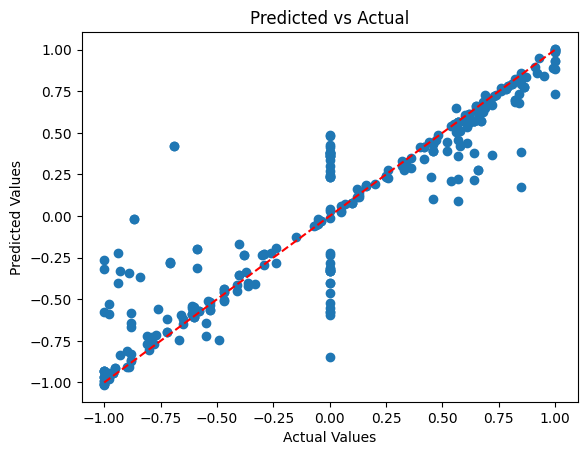

In [6]:
# Make predictions
final_predictions = regression_model.predict(d_test_2)
y_true = y_test_2

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, final_predictions))
mae = mean_absolute_error(y_true, final_predictions)
r2 = r2_score(y_true, final_predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

# Residual analysis
residuals = y_true - final_predictions
plt.hist(residuals, bins=30)
plt.title('Residual Histogram')
plt.show()

# Scatter plot of predicted vs. actual values
plt.scatter(y_true, final_predictions)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } 

Coverage scores: [0.944078947368421, 0.8947368421052632]


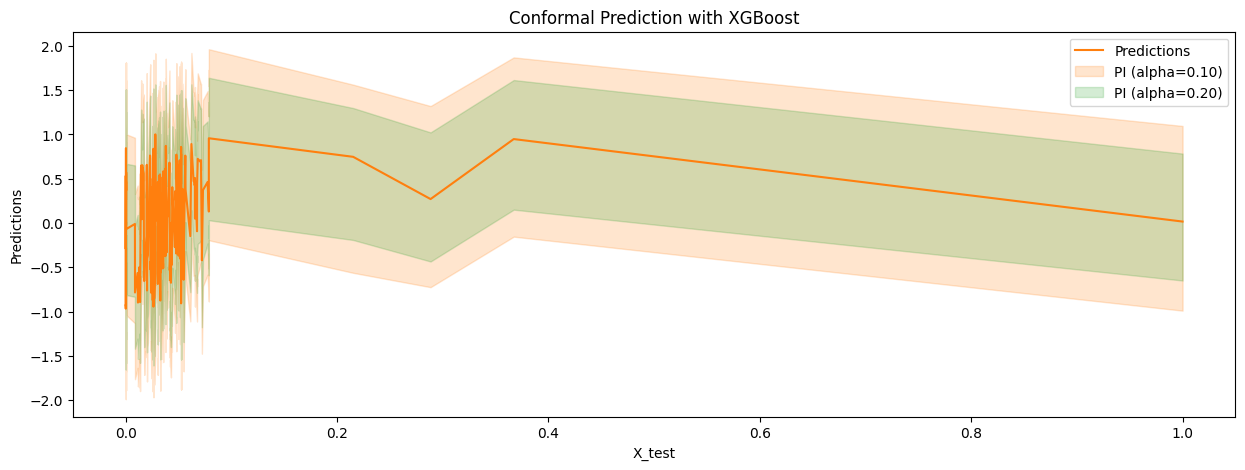

In [7]:
# Calibration dataset
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=random_state)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_2, y_train_2) # Trained on previous split for Regression model

# Apply conformal prediction
alpha = [0.1, 0.2]
mapie = MapieRegressor(estimator=xgb_model, method="plus", cv=10)
mapie.fit(X_calib, y_calib)

# Make predictions with prediction intervals
y_pred, y_pis = mapie.predict(X_test, alpha=alpha)

# Calculate coverage scores
coverage_scores = [
    regression_coverage_score(y_test, y_pis[:, 0, i], y_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]

# Display the results
print(f"Coverage scores: {coverage_scores}")

order = np.argsort(X_test.iloc[:, 0])  # Adjust sorting if necessary based on your feature of interest
plt.figure(figsize=(15, 5))
plt.plot(X_test.iloc[order, 0], y_pred[order], color="C1", label="Predictions")
plt.fill_between(
    X_test.iloc[order, 0],
    y_pis[order][:, 0, 0],
    y_pis[order][:, 1, 0],
    color="C1", alpha=0.2, label=f"PI (alpha={alpha[0]:.2f})"
)
plt.fill_between(
    X_test.iloc[order, 0],
    y_pis[order][:, 0, 1],
    y_pis[order][:, 1, 1],
    color="C2", alpha=0.2, label=f"PI (alpha={alpha[1]:.2f})"
)
plt.xlabel("X_test")
plt.ylabel("Predictions")
plt.title("Conformal Prediction with XGBoost")
plt.legend()
plt.show()

In [8]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import AnnotationBbox, TextArea

round_to = 2

def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """
    # axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
    # axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        label="Inside prediction interval"
        )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=np.abs(error[warnings]),
        capsize=5, marker="x", elinewidth=2, linewidth=0, color="red",
        label="Outside prediction interval"
        )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*", color="green",
        label="True value"
    )
    axs.set_xlabel("True Percent Change of LEDD")
    axs.set_ylabel("Prediction of Percent Change of LEDD")
    lims = [
    np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
    np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes
]
    # lims = [-1,1]
    ab = AnnotationBbox(
    TextArea(
        f"Coverage: {np.round(coverage, round_to)}\n"
        + f"Interval width: {np.round(width, round_to)}"
    ),
    xy=(lims[0] * 0.9, lims[1] * 0.9),  # Position annotation more relative to axis limits
    xycoords='data',
    boxcoords="offset points",
    frameon=True
    )
    axs.grid(True)
    axs.set_xlim(lims)
    axs.set_ylim(lims)
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold')

In [9]:
STRATEGIES = {
    "naive": {"method": "naive"},
    "cv_plus": {"method": "plus", "cv": 10},
    "jackknife_plus_ab": {"method": "plus", "cv": Subsample(n_resamplings=50)},
    # "cqr": {"method": "quantile", "cv": "split", "alpha": 0.2},
}
alpha = 0.2
y_pred, y_pis = {}, {}
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
coverage, width = {}, {}
for strategy, params in STRATEGIES.items():
    mapie = MapieRegressor(xgb_model,  test_size=0.2, **params, random_state=random_state) # Read more about test_size in MAPIE
    mapie.fit(X_train_2, y_train_2) # I have been playing with this
    y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=alpha)
    (y_test_sorted[strategy],y_pred_sorted[strategy],lower_bound[strategy],upper_bound[strategy]) = sort_y_values(y_test, y_pred[strategy], y_pis[strategy])
    coverage[strategy] = regression_coverage_score(y_test,y_pis[strategy][:, 0, 0],y_pis[strategy][:, 1, 0])
    width[strategy] = regression_mean_width_score(y_pis[strategy][:, 0, 0],y_pis[strategy][:, 1, 0])

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/sit

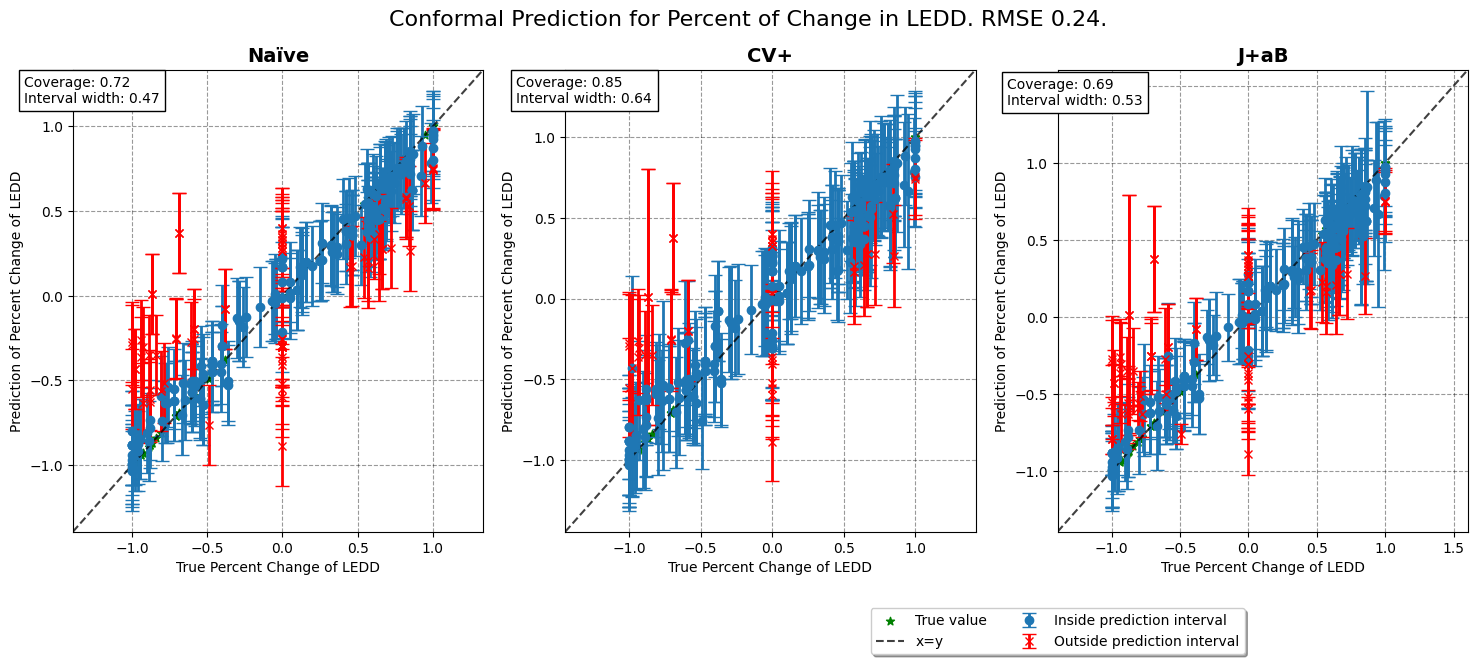

In [10]:
rng = np.random.default_rng(21)
perc_obs_plot = 0.90 # Percentage of observations in the ploting. Choosing to plot only X amount so that the graph doesn't look too clustered
num_plots = rng.choice(len(y_test), int(perc_obs_plot*len(y_test)), replace=False)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
coords = [axs[0], axs[1], axs[2]]

for strategy, coord in zip(STRATEGIES.keys(), coords):
    plot_prediction_intervals(
        strategy, coord, y_test_sorted[strategy], y_pred_sorted[strategy],
        lower_bound[strategy], upper_bound[strategy],
        coverage[strategy], width[strategy], num_plots
        )
    coord.grid(True, linestyle='--', alpha=0.4, linewidth=0.8, color='black')  # Add grid to each subplot

fig.suptitle(f'Conformal Prediction for Percent of Change in LEDD. RMSE {rmse:.2f}.', fontsize=16)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(_, []) for _ in zip(*lines_labels)] 
plt.legend(
    lines[:4], labels[:4],
    loc='upper center',
    bbox_to_anchor=(0, -0.15),
    fancybox=True,
    shadow=True,
    ncol=2
)
# axs[0].set_xlim(-1.15, 1.15)
axs[0].set_title("Naïve", fontsize=14, fontweight='bold')
# axs[1].set_xlim(-1.15, 1.15)
axs[1].set_title("CV+", fontsize=14, fontweight='bold')
# axs[2].set_xlim(-1.15, 1.15)
axs[2].set_title("J+aB", fontsize=14, fontweight='bold')
# plt.tight_layout() 
plt.show()

In [11]:
def split_into_five_equal_parts(X, y_binary, y_continuous, random_state=42):
    """
    Split data into 5 equal parts, maintaining alignment between binary and continuous outcomes
    
    Parameters:
    -----------
    X : features DataFrame
    y_binary : binary outcome (change/no change in LEDD)
    y_continuous : continuous outcome (normalized percentage change)
    random_state : for reproducibility
    
    Returns:
    --------
    Training, calibration, and test sets for both binary and continuous outcomes
    """
    # First split: 80% for train+calibration, 20% for test
    X_temp, X_test, y_binary_temp, y_binary_test, y_cont_temp, y_cont_test = train_test_split(
        X, y_binary, y_continuous, test_size=0.2, random_state=random_state
    )
    
    # Split the remaining 80% into 4 equal parts
    X_train, X_temp2, y_binary_train, y_binary_temp2, y_cont_train, y_cont_temp2 = train_test_split(
        X_temp, y_binary_temp, y_cont_temp, test_size=0.75, random_state=random_state
    )
    
    # Split the 60% into 3 equal calibration sets
    X_calib1, X_temp3, y_binary_calib1, y_binary_temp3, y_cont_calib1, y_cont_temp3 = train_test_split(
        X_temp2, y_binary_temp2, y_cont_temp2, test_size=0.666, random_state=random_state
    )
    
    X_calib2, X_calib3, y_binary_calib2, y_binary_calib3, y_cont_calib2, y_cont_calib3 = train_test_split(
        X_temp3, y_binary_temp3, y_cont_temp3, test_size=0.5, random_state=random_state
    )
    
    return (
        X_train, X_calib1, X_calib2, X_calib3, X_test,
        y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
        y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test
    )

In [12]:
def conformal_prediction_zero_inflated(X, y_binary, y_continuous, alpha_tilda=0.9):
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test,
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(
        X, y_binary, y_continuous
    )
    
    # Train classification model on binary outcome
    classifier = xgb.XGBClassifier(**binary_params)
    classifier.fit(X_train, y_binary_train)
    
    # Train regression model on non-zero continuous outcomes
    mask_nonzero = y_binary_train == 1
    regressor = xgb.XGBRegressor(**regression_params_short)
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    # First calibration set: Determine alpha_r
    probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
    r_values = np.arange(0.1, 0.95, 0.05)
    all_interval_lengths = []
    
    for r in r_values:
        alpha_r = np.quantile(probs_calib1, r)
        
        # Second calibration set: Calculate beta_hat
        probs_calib2 = classifier.predict_proba(X_calib2)[:, 1]
        pred_zeros = probs_calib2 <= alpha_r
        beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0)
        
        # Calculate final quantile
        final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
        if final_quantile < 0 or final_quantile > 1:
            continue
            
        # Third calibration set: Calculate interval width
        probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
        nonzero_mask = probs_calib3 > alpha_r
        if not any(nonzero_mask):
            continue
            
        y_pred_nonzero = regressor.predict(X_calib3[nonzero_mask])
        residuals = np.abs(y_cont_calib3[nonzero_mask] - y_pred_nonzero)
        interval_width = np.quantile(residuals, final_quantile)
        all_interval_lengths.append((r, interval_width, alpha_r))
    
    # Choose best r value and corresponding width
    best_r, best_width, best_alpha_r = min(all_interval_lengths, key=lambda x: x[1])
    
    # Make predictions on test set
    test_probs = classifier.predict_proba(X_test)[:, 1]
    test_pred = regressor.predict(X_test)
    
    # Create prediction intervals
    lower_bound = np.zeros_like(test_pred)
    upper_bound = np.zeros_like(test_pred)
    nonzero_mask = test_probs > best_alpha_r
    
    lower_bound[nonzero_mask] = test_pred[nonzero_mask] - best_width
    upper_bound[nonzero_mask] = test_pred[nonzero_mask] + best_width
    
    return lower_bound, upper_bound, y_cont_test

In [13]:
X = xgboost_df.iloc[:, :-1]  # All columns except the last one (prediction)

# Binary outcome (already exists in your code as y)
y_binary = xgboost_df.iloc[:, -1]  # The 'prediction' column

# Continuous outcome (you saved this earlier)
y_continuous = normalized_pctg_change

In [14]:
d_all = xgb.DMatrix(X)
y_pred_proba_all = model.predict(d_all, iteration_range=(0, model.best_iteration + 1))
y_pred_all = (y_pred_proba_all > 0.5).astype(int)

In [15]:
y_binary

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
        ... 
6100    0.00
6101    0.47
6102    0.00
6103    0.47
6104    0.00
Name: prediction, Length: 6105, dtype: float64

In [20]:
# 1. Without MAPIE
lower_bound, upper_bound, y_test = conformal_prediction_zero_inflated(
    X=X,
    y_binary=y_pred_all,
    y_continuous=y_continuous,
    alpha_tilda=0.9  # Target coverage (90%)
)

# Calculate and print coverage
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
interval_width = np.mean(upper_bound - lower_bound)
print(f"Coverage: {coverage:.3f}")
print(f"Average interval width: {interval_width:.3f}")

Coverage: 0.845
Average interval width: 0.139
